In [1]:
!tar xfvz /kaggle/input/ultralytics-for-offline-install/archive.tar.gz
!pip install --no-index --find-links=./packages ultralytics
!rm -rf ./packages

./packages/
./packages/pandas-2.2.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
./packages/nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl
./packages/numpy-2.1.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
./packages/psutil-6.1.0-cp36-abi3-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl
./packages/nvidia_nvtx_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl
./packages/nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl
./packages/charset_normalizer-3.4.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
./packages/nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl
./packages/torch-2.5.1-cp310-cp310-manylinux1_x86_64.whl
./packages/matplotlib-3.9.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
./packages/tqdm-4.67.1-py3-none-any.whl
./packages/networkx-3.4.2-py3-none-any.whl
./packages/typing_extensions-4.12.2-py3-none-any.whl
./packages/fonttools-4.55.1

In [2]:
import torch
import numpy as np
import cv2
import json
from pathlib import Path
from PIL import Image
from tqdm import tqdm

from ultralytics import YOLO
from transformers import AutoProcessor
from torchvision import transforms

from matplotlib import pyplot as plt
from ultralytics import YOLO

import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn as nn
import torch.nn.functional as F
from typing import Dict, List, Tuple, Any
import timm
from torchvision import transforms
from tqdm import tqdm
from pathlib import Path
from __future__ import annotations
import random
from PIL import Image

from dataclasses import dataclass
from transformers import AutoModel
import math
import os
import cv2
import json
import joblib

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


E0000 00:00:1768515152.070512      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768515152.123579      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768515152.563047      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768515152.563081      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768515152.563084      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768515152.563086      24 computation_placer.cc:177] computation placer already registered. Please check linka

# Config

In [3]:
class Config:
    SUBMISSION_MODE = len(
        os.listdir("/kaggle/input/recodai-luc-scientific-image-forgery-detection/test_images/")
    ) > 1
    TRAIN_IMG_DIR = "/kaggle/input/recodai-luc-scientific-image-forgery-detection/train_images/forged/"
    TEST_IMG_DIR = "/kaggle/input/recodai-luc-scientific-image-forgery-detection/test_images"
    SUPPLEMENTAL_IMG_DIR = "/kaggle/input/recodai-luc-scientific-image-forgery-detection/supplemental_images"
    DINO_PATH = "/kaggle/input/dinov2/pytorch/base/1"
    SUBMISSION_DF = "/kaggle/input/recodai-luc-scientific-image-forgery-detection/sample_submission.csv"
    SEED = 42
    DETECTOR_PATH = "/kaggle/input/recodai-panel-detector/best.pt"

def set_seed(seed: int) -> None:
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(Config.SEED)

# Models

#### Dinov2Unet

In [4]:
class ConvBNReLU(nn.Module):
    def __init__(self, in_ch: int, out_ch: int, k: int = 3, p: int = 1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=k, padding=p, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class DecoderBlock(nn.Module):
    """
    UNet-style decoder block:
    - upsample x
    - concat with skip
    - convs
    """

    def __init__(self, in_ch: int, skip_ch: int, out_ch: int):
        super().__init__()
        self.conv1 = ConvBNReLU(in_ch + skip_ch, out_ch, k=3, p=1)
        self.conv2 = ConvBNReLU(out_ch, out_ch, k=3, p=1)

    def forward(self, x: torch.Tensor, skip: torch.Tensor) -> torch.Tensor:
        x = F.interpolate(x, size=skip.shape[-2:], mode="bilinear", align_corners=False)
        x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x


@dataclass
class DinoV2Config:
    model_id: str = "facebook/dinov2-base"
    out_indices: Tuple[int, int, int, int] = (2, 5, 8, 11)
    patch_size: int = 14


class DinoV2HookBackbone(nn.Module):
    """
    DINOv2 backbone that returns 4 feature maps from intermediate blocks.
    Each feature map is (B, C, H/ps, W/ps).
    """

    def __init__(self, cfg: DinoV2Config):
        super().__init__()
        self.cfg = cfg
        self.encoder = AutoModel.from_pretrained(cfg.model_id, local_files_only=True)

        self.hidden_size = int(self.encoder.config.hidden_size)

        self._feats: Dict[int, torch.Tensor] = {}
        self._out_indices = set(cfg.out_indices)

        blocks = self.encoder.encoder.layer
        for i, blk in enumerate(blocks):
            blk.register_forward_hook(self._make_hook(i))

    def _make_hook(self, idx: int):
        def hook(module, inp, out):
            # HF blocks can return tuples; keep the hidden states tensor.
            if isinstance(out, (list, tuple)):
                out = out[0]
            self._feats[idx] = out

        return hook

    @torch.no_grad()
    def freeze(self) -> None:
        for p in self.encoder.parameters():
            p.requires_grad = False

    def unfreeze_last_blocks(self, n_last: int = 4) -> None:
        blocks = self.encoder.encoder.layer
        n = len(blocks)
        for i, blk in enumerate(blocks):
            req = i >= (n - n_last)
            for p in blk.parameters():
                p.requires_grad = req

    def forward(self, x: torch.Tensor) -> List[torch.Tensor]:
        self._feats = {}
        _ = self.encoder(pixel_values=x, return_dict=True, output_hidden_states=False)

        b, _, h, w = x.shape
        gh = h // self.cfg.patch_size
        gw = w // self.cfg.patch_size

        feats: List[torch.Tensor] = []
        for idx in self.cfg.out_indices:
            t = self._feats[idx]
            t = t[:, 1:, :]
            fmap = t.transpose(1, 2).contiguous().view(b, self.hidden_size, gh, gw)
            feats.append(fmap)

        return feats


class DinoV2UNet(nn.Module):
    """
    UNet-like decoder operating on same-resolution token maps (gh x gw),
    using intermediate depth features as "skip" connections.
    """

    def __init__(
        self,
        dinov2_id: str = "facebook/dinov2-base",
        out_indices: Tuple[int, int, int, int] = (2, 5, 8, 11),
        patch_size: int = 14,
        dec_channels: Tuple[int, int, int, int] = (512, 256, 192, 128),
        out_classes: int = 1,
    ):
        super().__init__()
        cfg = DinoV2Config(model_id=dinov2_id, out_indices=out_indices, patch_size=patch_size)
        self.backbone = DinoV2HookBackbone(cfg)
        c = self.backbone.hidden_size

        self.proj1 = nn.Conv2d(c, dec_channels[3], kernel_size=1)
        self.proj2 = nn.Conv2d(c, dec_channels[2], kernel_size=1)
        self.proj3 = nn.Conv2d(c, dec_channels[1], kernel_size=1)
        self.proj4 = nn.Conv2d(c, dec_channels[0], kernel_size=1)

        self.dec3 = DecoderBlock(in_ch=dec_channels[0], skip_ch=dec_channels[1], out_ch=dec_channels[1])
        self.dec2 = DecoderBlock(in_ch=dec_channels[1], skip_ch=dec_channels[2], out_ch=dec_channels[2])
        self.dec1 = DecoderBlock(in_ch=dec_channels[2], skip_ch=dec_channels[3], out_ch=dec_channels[3])

        self.refine = nn.Sequential(
            ConvBNReLU(dec_channels[3], dec_channels[3], k=3, p=1),
            nn.Dropout2d(0.1),
            nn.Conv2d(dec_channels[3], out_classes, kernel_size=1),
        )

    def forward(self, images: torch.Tensor) -> torch.Tensor:
        feats = self.backbone(images)
        f1, f2, f3, f4 = feats

        s1 = self.proj1(f1)
        s2 = self.proj2(f2)
        s3 = self.proj3(f3)
        x = self.proj4(f4)

        x = self.dec3(x, s3)
        x = self.dec2(x, s2)
        x = self.dec1(x, s1)

        logits_small = self.refine(x)
        logits = F.interpolate(logits_small, size=images.shape[-2:], mode="bilinear", align_corners=False)
        return logits


#### Dinov2Uperhead

In [5]:
class ConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, p=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=k, padding=p, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)


class PSPModule(nn.Module):
    """Pyramid pooling on top-level feature map."""

    def __init__(self, in_ch, out_ch, pool_sizes=(1, 2, 3, 6)):
        super().__init__()
        self.stages = nn.ModuleList()
        for ps in pool_sizes:
            self.stages.append(
                nn.Sequential(
                    nn.AdaptiveAvgPool2d(ps),
                    nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False),
                    nn.BatchNorm2d(out_ch),
                    nn.ReLU(inplace=True),
                )
            )
        self.bottleneck = ConvBNReLU(in_ch + len(pool_sizes) * out_ch, out_ch, k=3, p=1)

    def forward(self, x):
        h, w = x.shape[-2:]
        priors = [x]
        for stage in self.stages:
            y = stage(x)
            y = F.interpolate(y, size=(h, w), mode="bilinear", align_corners=False)
            priors.append(y)
        x = torch.cat(priors, dim=1)
        return self.bottleneck(x)


class UPerHead(nn.Module):
    """
    UPerNet head: PSP on last feature + FPN fusion.
    feats: list of feature maps [C2, C3, C4, C5] (low->high level)
    """

    def __init__(self, in_channels_list, channels=256, num_classes=1):
        super().__init__()
        assert len(in_channels_list) == 4, "Expect 4 feature levels"
        self.lateral_convs = nn.ModuleList([nn.Conv2d(c, channels, 1) for c in in_channels_list])
        self.fpn_convs = nn.ModuleList([ConvBNReLU(channels, channels) for _ in in_channels_list])

        self.psp = PSPModule(channels, channels)

        self.fuse = ConvBNReLU(channels * 4, channels)
        self.classifier = nn.Conv2d(channels, num_classes, kernel_size=1)

    def forward(self, feats):
        laterals = [lat(f) for lat, f in zip(self.lateral_convs, feats)]

        laterals[-1] = self.psp(laterals[-1])

        for i in range(2, -1, -1):
            up = F.interpolate(laterals[i + 1], size=laterals[i].shape[-2:], mode="bilinear", align_corners=False)
            laterals[i] = laterals[i] + up

        outs = [fpn(lat) for fpn, lat in zip(self.fpn_convs, laterals)]

        target_size = outs[0].shape[-2:]
        outs = [outs[0]] + [F.interpolate(o, size=target_size, mode="bilinear", align_corners=False) for o in outs[1:]]
        x = self.fuse(torch.cat(outs, dim=1))
        return self.classifier(x)


class DinoV2Backbone(nn.Module):
    """
    Extract intermediate block tokens from DINOv2 and reshape to feature maps.
    """

    def __init__(self, model_id: str, out_indices=(2, 5, 8, 11)):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_id, local_files_only=True)
        self.out_indices = set(out_indices)

        self._features = {}
        for i, blk in enumerate(self.encoder.encoder.layer):
            blk.register_forward_hook(self._make_hook(i))

        self.hidden_size = self.encoder.config.hidden_size
        self.patch_size = 14

    def _make_hook(self, idx):
        def hook(module, inp, out):
            # HF blocks can return tuples; keep the hidden states tensor.
            if isinstance(out, (list, tuple)):
                out = out[0]
            self._features[idx] = out

        return hook

    def forward(self, x):
        self._features = {}
        _ = self.encoder(pixel_values=x, output_hidden_states=False, return_dict=True)
        feats = []
        b, _, h, w = x.shape

        gh = h // self.patch_size
        gw = w // self.patch_size

        for idx in sorted(self.out_indices):
            t = self._features[idx]
            t = t[:, 1:, :]
            fmap = t.transpose(1, 2).contiguous().view(b, self.hidden_size, gh, gw)
            feats.append(fmap)

        return feats


class DinoV2_UPerNet(nn.Module):
    def __init__(self, dinov2_id: str, num_classes=1, uper_channels=256, out_indices=(2, 5, 8, 11)):
        super().__init__()
        self.backbone = DinoV2Backbone(dinov2_id, out_indices=out_indices)
        in_list = [self.backbone.hidden_size] * 4
        self.decode_head = UPerHead(in_list, channels=uper_channels, num_classes=num_classes)

    def forward(self, images):
        feats = self.backbone(images)
        logits_small = self.decode_head(feats)
        logits = F.interpolate(logits_small, size=images.shape[-2:], mode="bilinear", align_corners=False)
        return logits

# Submission Utils

In [6]:
import json

import numba
import numpy as np
from numba import types
import numpy.typing as npt
import pandas as pd
import scipy.optimize


class ParticipantVisibleError(Exception):
    pass


@numba.jit(nopython=True)
def _rle_encode_jit(x: npt.NDArray, fg_val: int = 1) -> list[int]:
    """Numba-jitted RLE encoder."""
    dots = np.where(x.T.flatten() == fg_val)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def rle_encode(masks: list[npt.NDArray], fg_val: int = 1) -> str:
    """
    Adapted from contrails RLE https://www.kaggle.com/code/inversion/contrails-rle-submission
    Args:
        masks: list of numpy array of shape (height, width), 1 - mask, 0 - background
    Returns: run length encodings as a string, with each RLE JSON-encoded and separated by a semicolon.
    """
    return ';'.join([json.dumps(_rle_encode_jit(x, fg_val)) for x in masks])


@numba.njit
def _rle_decode_jit(mask_rle: npt.NDArray, height: int, width: int) -> npt.NDArray:
    """
    s: numpy array of run-length encoding pairs (start, length)
    shape: (height, width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    """
    if len(mask_rle) % 2 != 0:
        # Numba requires raising a standard exception.
        raise ValueError('One or more rows has an odd number of values.')

    starts, lengths = mask_rle[0::2], mask_rle[1::2]
    starts -= 1
    ends = starts + lengths
    for i in range(len(starts) - 1):
        if ends[i] > starts[i + 1]:
            raise ValueError('Pixels must not be overlapping.')
    img = np.zeros(height * width, dtype=np.bool_)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img


def rle_decode(mask_rle: str, shape: tuple[int, int]) -> npt.NDArray:
    """
    mask_rle: run-length as string formatted (start length)
              empty predictions need to be encoded with '-'
    shape: (height, width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    """

    mask_rle = json.loads(mask_rle)
    mask_rle = np.asarray(mask_rle, dtype=np.int32)
    starts = mask_rle[0::2]
    if sorted(starts) != list(starts):
        raise ParticipantVisibleError('Submitted values must be in ascending order.')
    try:
        return _rle_decode_jit(mask_rle, shape[0], shape[1]).reshape(shape, order='F')
    except ValueError as e:
        raise ParticipantVisibleError(str(e)) from e


def calculate_f1_score(pred_mask: npt.NDArray, gt_mask: npt.NDArray):
    pred_flat = pred_mask.flatten()
    gt_flat = gt_mask.flatten()

    tp = np.sum((pred_flat == 1) & (gt_flat == 1))
    fp = np.sum((pred_flat == 1) & (gt_flat == 0))
    fn = np.sum((pred_flat == 0) & (gt_flat == 1))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    if (precision + recall) > 0:
        return 2 * (precision * recall) / (precision + recall)
    else:
        return 0


def calculate_f1_matrix(pred_masks: list[npt.NDArray], gt_masks: list[npt.NDArray]):
    """
    Parameters:
    pred_masks (np.ndarray):
            First dimension is the number of predicted instances.
            Each instance is a binary mask of shape (height, width).
    gt_masks (np.ndarray):
            First dimension is the number of ground truth instances.
            Each instance is a binary mask of shape (height, width).
    """

    num_instances_pred = len(pred_masks)
    num_instances_gt = len(gt_masks)
    f1_matrix = np.zeros((num_instances_pred, num_instances_gt))

    # Calculate F1 scores for each pair of predicted and ground truth masks
    for i in range(num_instances_pred):
        for j in range(num_instances_gt):
            pred_flat = pred_masks[i].flatten()
            gt_flat = gt_masks[j].flatten()
            f1_matrix[i, j] = calculate_f1_score(pred_mask=pred_flat, gt_mask=gt_flat)

    if f1_matrix.shape[0] < len(gt_masks):
        # Add a row of zeros to the matrix if the number of predicted instances is less than ground truth instances
        f1_matrix = np.vstack((f1_matrix, np.zeros((len(gt_masks) - len(f1_matrix), num_instances_gt))))

    return f1_matrix


def oF1_score(pred_masks: list[npt.NDArray], gt_masks: list[npt.NDArray]):
    """
    Calculate the optimal F1 score for a set of predicted masks against
    ground truth masks which considers the optimal F1 score matching.
    This function uses the Hungarian algorithm to find the optimal assignment
    of predicted masks to ground truth masks based on the F1 score matrix.
    If the number of predicted masks is less than the number of ground truth masks,
    it will add a row of zeros to the F1 score matrix to ensure that the dimensions match.

    Parameters:
    pred_masks (list of np.ndarray): List of predicted binary masks.
    gt_masks (np.ndarray): Array of ground truth binary masks.
    Returns:
    float: Optimal F1 score.
    """
    f1_matrix = calculate_f1_matrix(pred_masks, gt_masks)

    # Find the best matching between predicted and ground truth masks
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(-f1_matrix)
    # The linear_sum_assignment discards excess predictions so we need a separate penalty.
    excess_predictions_penalty = len(gt_masks) / max(len(pred_masks), len(gt_masks))
    return np.mean(f1_matrix[row_ind, col_ind]) * excess_predictions_penalty


def evaluate_single_image(label_rles: str, prediction_rles: str, shape_str: str) -> float:
    shape = json.loads(shape_str)
    label_rles = [rle_decode(x, shape=shape) for x in label_rles.split(';')]
    prediction_rles = [rle_decode(x, shape=shape) for x in prediction_rles.split(';')]
    return oF1_score(prediction_rles, label_rles)


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    """
    Args:
        solution (pd.DataFrame): The ground truth DataFrame.
        submission (pd.DataFrame): The submission DataFrame.
        row_id_column_name (str): The name of the column containing row IDs.
    Returns:
        float

    Examples
    --------
    >>> solution = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['authentic', 'authentic', 'authentic'], 'shape': ['authentic', 'authentic', 'authentic']})
    >>> submission = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['authentic', 'authentic', 'authentic']})
    >>> score(solution.copy(), submission.copy(), row_id_column_name='row_id')
    1.0

    >>> solution = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['authentic', 'authentic', 'authentic'], 'shape': ['authentic', 'authentic', 'authentic']})
    >>> submission = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['[101, 102]', '[101, 102]', '[101, 102]']})
    >>> score(solution.copy(), submission.copy(), row_id_column_name='row_id')
    0.0

    >>> solution = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['[101, 102]', '[101, 102]', '[101, 102]'], 'shape': ['[720, 960]', '[720, 960]', '[720, 960]']})
    >>> submission = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['[101, 102]', '[101, 102]', '[101, 102]']})
    >>> score(solution.copy(), submission.copy(), row_id_column_name='row_id')
    1.0

    >>> solution = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['[101, 103]', '[101, 102]', '[101, 102]'], 'shape': ['[720, 960]', '[720, 960]', '[720, 960]']})
    >>> submission = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['[101, 102]', '[101, 102]', '[101, 102]']})
    >>> score(solution.copy(), submission.copy(), row_id_column_name='row_id')
    0.9983739837398374

    >>> solution = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['[101, 102];[300, 100]', '[101, 102]', '[101, 102]'], 'shape': ['[720, 960]', '[720, 960]', '[720, 960]']})
    >>> submission = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['[101, 102]', '[101, 102]', '[101, 102]']})
    >>> score(solution.copy(), submission.copy(), row_id_column_name='row_id')
    0.8333333333333334
    """
    df = solution
    df = df.rename(columns={'annotation': 'label'})

    df['prediction'] = submission['annotation']
    # Check for correct 'authentic' label
    authentic_indices = (df['label'] == 'authentic') | (df['prediction'] == 'authentic')
    df['image_score'] = ((df['label'] == df['prediction']) & authentic_indices).astype(float)

    df.loc[~authentic_indices, 'image_score'] = df.loc[~authentic_indices].apply(
        lambda row: evaluate_single_image(row['label'], row['prediction'], row['shape']), axis=1
    )
    return float(np.mean(df['image_score']))

In [7]:
# Inference

from pathlib import Path
from torch.utils.data import DataLoader, Subset
from torch.utils.data.dataloader import default_collate
import numpy as np
import torch
import cv2
import math
import random
from PIL import Image
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

img_size = 532
margin = 20
best_params = {
    # evaluated
    "/kaggle/input/recordai-dinov2-uperhead-no-pos-weight/vit_base_patch14_dinov2.lvd142m_fold0.pt": dict(
        # cc based
        area_thres = 100,
        mean_in_thres = 0.65,
        min_cc_area = 200,
    ),
    "/kaggle/input/recodai-dinov2-unet-pos-weight-4/vit_base_patch14_dinov2.lvd142m_fold0.pt": dict(
        area_thres = 600,
        mean_in_thres = 0.65,
        min_cc_area = 200,
    ),
    "/kaggle/input/recodai-nposw-uperhead-more-aug-dinov2-uperhead/20260115_182834/vit_base_patch14_dinov2.lvd142m_fold0.pt": dict(
        area_thres=5e-5,         # best params
        mean_in_thres=0.6,
        min_cc_area=200,
        use_area_ratio=True,
    )
    
}

detect_params = dict(
    yolo_img_size = 1024,
    yolo_conf = 0.25,
    yolo_iou = 0.6,
)

img_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225],
    ),
])


device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)


def apply_clahe(image: Image.Image) -> Image.Image:
    img_np = np.array(image)
    lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l2 = clahe.apply(l)
    lab2 = cv2.merge((l2, a, b))
    enhanced = cv2.cvtColor(lab2, cv2.COLOR_LAB2RGB)
    return Image.fromarray(enhanced)


def enhanced_adaptive_mask(prob: np.ndarray, alpha_grad=0.45):
    prob = np.asarray(prob, dtype=np.float32)
    if prob.ndim == 3:
        prob = prob[..., 0]

    gx = cv2.Sobel(prob, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(prob, cv2.CV_32F, 0, 1, ksize=3)
    grad_mag = np.sqrt(gx**2 + gy**2)
    grad_norm = grad_mag / (grad_mag.max() + 1e-6)

    enhanced = (1 - alpha_grad) * prob + alpha_grad * grad_norm
    enhanced = cv2.GaussianBlur(enhanced, (3, 3), 0)

    thr = float(np.mean(enhanced) + 0.3 * np.std(enhanced))
    mask = (enhanced > thr).astype(np.uint8)

    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
    return mask, thr


def finalize_mask(prob: np.ndarray, orig_size_wh: tuple[int, int]):
    mask, thr = enhanced_adaptive_mask(prob)
    w, h = orig_size_wh
    mask = cv2.resize(mask, (int(w), int(h)), interpolation=cv2.INTER_NEAREST)
    return mask, thr


def remove_small_components(mask01: np.ndarray, min_area: int) -> np.ndarray:
    if min_area is None or min_area <= 0:
        return (mask01 > 0).astype(np.uint8)

    m = (mask01 > 0).astype(np.uint8)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(m, connectivity=8)

    out = np.zeros_like(m, dtype=np.uint8)
    for lab in range(1, num_labels):
        if stats[lab, cv2.CC_STAT_AREA] >= min_area:
            out[labels == lab] = 1
    return out


def preprocess(image: Image.Image, base_model_preprocessor, img_size: int = 532):
    image = apply_clahe(image)
    image = transforms.functional.resize(image, (img_size, img_size))
    processed = base_model_preprocessor(
        images=image,
        return_tensors="pt",
        do_resize=False,
        do_center_crop=False,
        do_normalize=True,
        do_rescale=True,
    )
    return processed["pixel_values"].squeeze(0)  # [C,H,W]

def load_gt_mask_from_image_path(image_path: str, w: int, h: int) -> np.ndarray:
    mask_path = (
        image_path
        .replace("train_images", "train_masks")
        .replace("supplemental_images", "supplemental_masks")
        .replace("/forged", "")
        .replace(".png", ".npy")
    )
    if not Path(mask_path).exists():
        return np.zeros((h, w), dtype=np.uint8)

    arr = np.load(mask_path, allow_pickle=True)
    if arr.ndim == 3:
        arr = arr.max(axis=0)
    gt_mask = (arr > 0).astype(np.uint8)
    if gt_mask.shape[:2] != (h, w):
        gt_mask = cv2.resize(gt_mask, (w, h), interpolation=cv2.INTER_NEAREST)
    return gt_mask

def apply_overlay_rgb(img_rgb: np.ndarray, mask01: np.ndarray, color=(255, 0, 0), alpha=0.45):
    """
    img_rgb: (H,W,3) uint8
    mask01: (H,W) {0,1} or {0,255}
    """
    out = img_rgb.copy()
    m = (mask01 > 0)
    if m.any():
        col = np.array(color, dtype=np.float32)
        out[m] = (alpha * col + (1 - alpha) * out[m].astype(np.float32)).astype(np.uint8)
    return out

def draw_yolo_boxes(img_rgb: np.ndarray, boxes_xyxy: np.ndarray, color=(255, 0, 0), thickness=2):
    """
    Draws xyxy boxes on RGB image. Uses cv2 (expects BGR), so we convert back/forth.
    boxes_xyxy: (N,4) float or int in xyxy.
    """
    if boxes_xyxy is None or len(boxes_xyxy) == 0:
        return img_rgb

    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
    for b in boxes_xyxy:
        x1, y1, x2, y2 = [int(round(v)) for v in b.tolist()]
        cv2.rectangle(img_bgr, (x1, y1), (x2, y2), color[::-1], thickness)  # reverse to BGR
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)


def inference(
    img_dir: Path,
    weight_path: str,
    arch: str,
    samples: int = 10,
) -> pd.DataFrame:
    
    # Loading detector
    detect_model = YOLO(Config.DETECTOR_PATH)

    state = torch.load(weight_path, map_location=device)
    model_state = state["model_state"]
    
    if arch == "dinov2_uperhead":
        seg_model = DinoV2_UPerNet(dinov2_id=Config.DINO_PATH, num_classes=1).to(device)
    elif arch == "dinov2_unet":
        seg_model = DinoV2UNet(dinov2_id=Config.DINO_PATH, out_classes=1).to(device)
    else:
        raise ValueError(f"Unknown arch: {arch}")

    seg_model.load_state_dict(model_state)
    seg_model.eval()


    submission_rows = []

    params = best_params[str(weight_path)]
    area_thres = params["area_thres"]
    mean_in_thres = params["mean_in_thres"]
    min_cc_area = params["min_cc_area"]

    @torch.no_grad()
    def get_seg_mask_raw(image: Image.Image, H: int, W: int, use_tta: bool = True):
        """
        Returns:
          pred_bin_full : (H,W) uint8 {0,1}  -> UNION of per-TTA masks
          prob_full_max : (H,W) float32      -> MAX of per-TTA probs (for mean_inside gating)
          prob_full_avg : (H,W) float32      -> AVG of per-TTA probs (optional viz)
        """
        base = apply_clahe(image)
    
        tta = [(False, False)]
        if use_tta:
            tta += [(True, False), (False, True)]   # hflip, vflip
            # optional:
            # tta += [(True, True)]
    
        prob_sum = None
        prob_max = None
        mask_union = None
    
        for hflip, vflip in tta:
            img_t = base
            if hflip:
                img_t = img_t.transpose(Image.FLIP_LEFT_RIGHT)
            if vflip:
                img_t = img_t.transpose(Image.FLIP_TOP_BOTTOM)
    
            x = img_transform(img_t).unsqueeze(0).to(device)
            out = seg_model(x)
            logits = out if torch.is_tensor(out) else out[0]
            prob_small = torch.sigmoid(logits)[0, 0].detach().cpu().numpy().astype(np.float32)
    
            # unflip back
            if hflip:
                prob_small = prob_small[:, ::-1]
            if vflip:
                prob_small = prob_small[::-1, :]
    
            prob_small = np.ascontiguousarray(prob_small, dtype=np.float32)
    
            # accumulate avg + max (MODEL-RES)
            if prob_sum is None:
                prob_sum = prob_small.copy()
                prob_max = prob_small.copy()
            else:
                prob_sum += prob_small
                prob_max = np.maximum(prob_max, prob_small)
    
            # make per-tta mask and UNION it (orig-res)
            m_full, _ = finalize_mask(prob_small, (W, H))
            m_full = (m_full > 0).astype(np.uint8)
    
            if mask_union is None:
                mask_union = m_full
            else:
                mask_union = np.maximum(mask_union, m_full)
    
        prob_avg = prob_sum / float(len(tta))
    
        # resize probs to FULL-res
        prob_full_max = cv2.resize(prob_max, (W, H), interpolation=cv2.INTER_LINEAR).astype(np.float32)
        prob_full_avg = cv2.resize(prob_avg, (W, H), interpolation=cv2.INTER_LINEAR).astype(np.float32)
    
        return mask_union.astype(np.uint8), prob_full_max


    scores = []
    for idx, img_path in enumerate(img_dir.glob("*")):
        case_id = img_path.stem

        try:
            image = Image.open(img_path).convert("RGB")
        except:
            submission_rows.append({"case_id": str(case_id), "annotation": "authentic"})
            continue
            
        W, H = image.size
        predicted_mask = np.zeros((H, W), dtype=np.uint8)
    
        preds = detect_model.predict(
            source=str(img_path),
            conf=detect_params["yolo_conf"],
            iou=detect_params["yolo_iou"],
            imgsz=detect_params["yolo_img_size"],
            verbose=False
        )
    
        pred_union = np.zeros((H, W), dtype=np.uint8)
        prob_accum = np.zeros((H, W), dtype=np.float32)
        prob_count = np.zeros((H, W), dtype=np.float32)
        
        # YOLO predict ...
        boxes = preds[0].boxes
        
        if boxes is None or len(boxes) <= 1:
            pred_bin, prob_full = get_seg_mask_raw(image, H=H, W=W)
            pred_union = np.maximum(pred_union, pred_bin)
            prob_accum += prob_full
            prob_count += 1.0
        else:
            for bbox in boxes.xyxy.cpu().numpy():
                x1, y1, x2, y2 = bbox.tolist()
                x1 = int(max(0, x1)); y1 = int(max(0, y1))
                x2 = int(min(W, x2)); y2 = int(min(H, y2))
        
                x1m = max(0, min(W-1, x1 + margin))
                y1m = max(0, min(H-1, y1 + margin))
                x2m = max(1, min(W,   x2 - margin))
                y2m = max(1, min(H,   y2 - margin))
                if x2m <= x1m or y2m <= y1m:
                    continue
        
                crop = image.crop((x1m, y1m, x2m, y2m))
                cw, ch = crop.size
        
                pred_bin, prob_full = get_seg_mask_raw(crop, H=ch, W=cw)
        
                pred_union[y1m:y2m, x1m:x2m] = np.maximum(pred_union[y1m:y2m, x1m:x2m], pred_bin)
                prob_accum[y1m:y2m, x1m:x2m] += prob_full
                prob_count[y1m:y2m, x1m:x2m] += 1.0
        
        prob_vis = prob_accum / np.maximum(prob_count, 1e-6)
        # CC ONCE (global)
        # predicted_mask = prob_vis
        predicted_mask = remove_small_components(pred_union, min_cc_area)
        
        # compute area metric
        area_px = int(predicted_mask.sum())
        if params.get("use_area_ratio", False):
            area_metric = area_px / float(H * W)
        else:
            area_metric = float(area_px)
        
        # mean inside on merged prob_vis
        mean_inside = float(prob_vis[predicted_mask == 1].mean()) if area_px > 0 else 0.0
        
        is_forged = (area_metric >= area_thres) and (mean_inside >= mean_in_thres)
        if not is_forged:
            predicted_mask[:] = 0

        if predicted_mask.sum() > 0:
            submission_rows.append({"case_id": str(case_id), "annotation": rle_encode([predicted_mask])})
        else:
            submission_rows.append({"case_id": str(case_id), "annotation": "authentic"})

        if Config.SUBMISSION_MODE:
            continue

        if idx == samples:
            break

        # Evaluate vs GT (supplemental has masks)
        gt_mask = load_gt_mask_from_image_path(str(img_path), w=W, h=H)
    
        label_rles = rle_encode([gt_mask])
        prediction_rles = rle_encode([predicted_mask])
    
        score = evaluate_single_image(
            label_rles=label_rles,
            prediction_rles=prediction_rles,
            shape_str=json.dumps([int(H), int(W)])
        )
        scores.append(score)
    
        # quick visualize
        img_np = np.array(image)  # RGB uint8
    
        # Collect bbox array to draw (use original clamped coords x1,y1,x2,y2; not margin-cropped)
        boxes_xyxy = None
        if boxes is not None and len(boxes) > 0:
            boxes_xyxy = boxes.xyxy.cpu().numpy()
    
        img_with_boxes = draw_yolo_boxes(img_np, boxes_xyxy, color=(255, 0, 0), thickness=3)
    
        pred_overlay = apply_overlay_rgb(img_np, predicted_mask, color=(255, 0, 0), alpha=0.45)  # red
        gt_overlay   = apply_overlay_rgb(img_np, gt_mask,        color=(255, 0, 0), alpha=0.45)  # green
    
        # Both overlays on same image (GT green + Pred red)
        both_overlay = img_np.copy()
        both_overlay = apply_overlay_rgb(both_overlay, gt_mask,        color=(255, 0, 0), alpha=0.35)
        both_overlay = apply_overlay_rgb(both_overlay, predicted_mask, color=(255, 0, 0), alpha=0.35)
        both_overlay = draw_yolo_boxes(both_overlay, boxes_xyxy, color=(255, 0, 0), thickness=3)
    
        plt.figure(figsize=(18, 10))
    
        plt.subplot(2, 3, 1)
        plt.title("Input + YOLO boxes")
        plt.imshow(img_with_boxes); plt.axis("off")
    
        plt.subplot(2, 3, 2)
        plt.title(f"Pred mask: {score}")
        plt.imshow(predicted_mask, cmap="gray"); plt.axis("off")
    
        plt.subplot(2, 3, 3)
        plt.title("GT mask")
        plt.imshow(gt_mask, cmap="gray"); plt.axis("off")
    
        plt.subplot(2, 3, 4)
        plt.title("Pred overlay (red)")
        plt.imshow(pred_overlay); plt.axis("off")
    
        plt.subplot(2, 3, 5)
        plt.title("GT overlay (green)")
        plt.imshow(gt_overlay); plt.axis("off")
    
        plt.subplot(2, 3, 6)
        plt.title(f"GT+Pred overlay + boxes (score={score:.4f})")
        plt.imshow(both_overlay); plt.axis("off")
    
        plt.tight_layout()
        plt.show()
        
    submission_df = pd.DataFrame(submission_rows)
    submission_df["case_id"] = submission_df["case_id"].astype(str)
    submission_df.to_csv("submission.csv", index=False)
    return submission_df

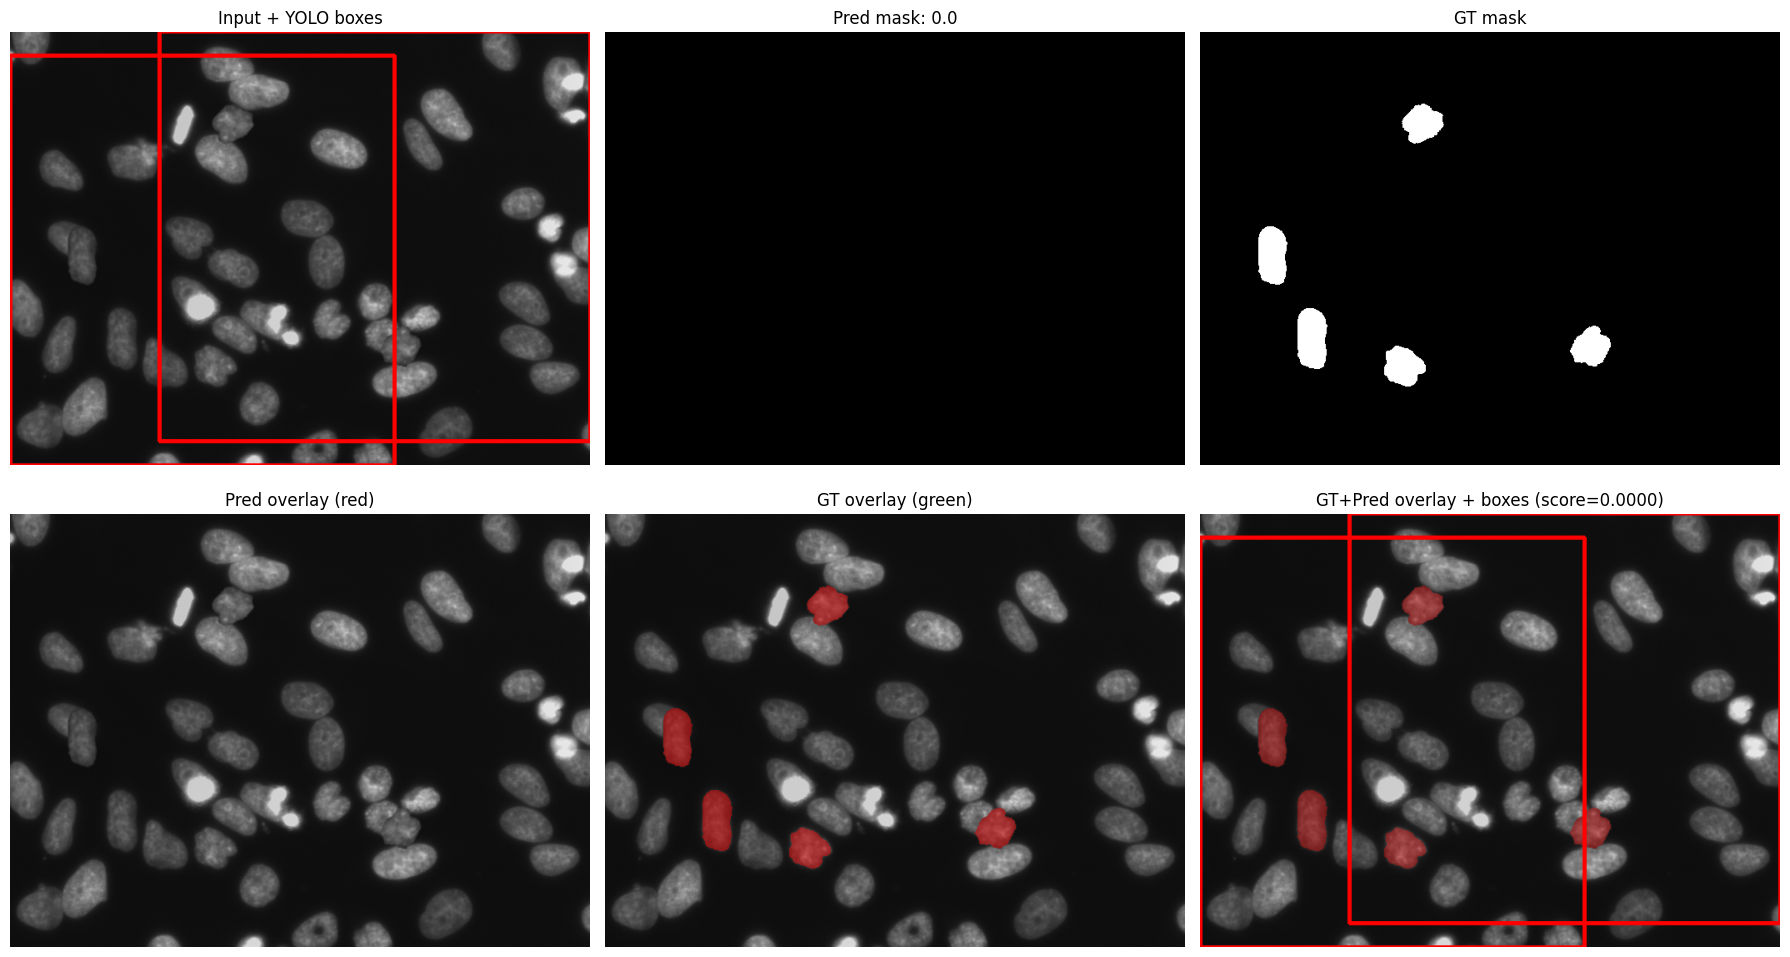

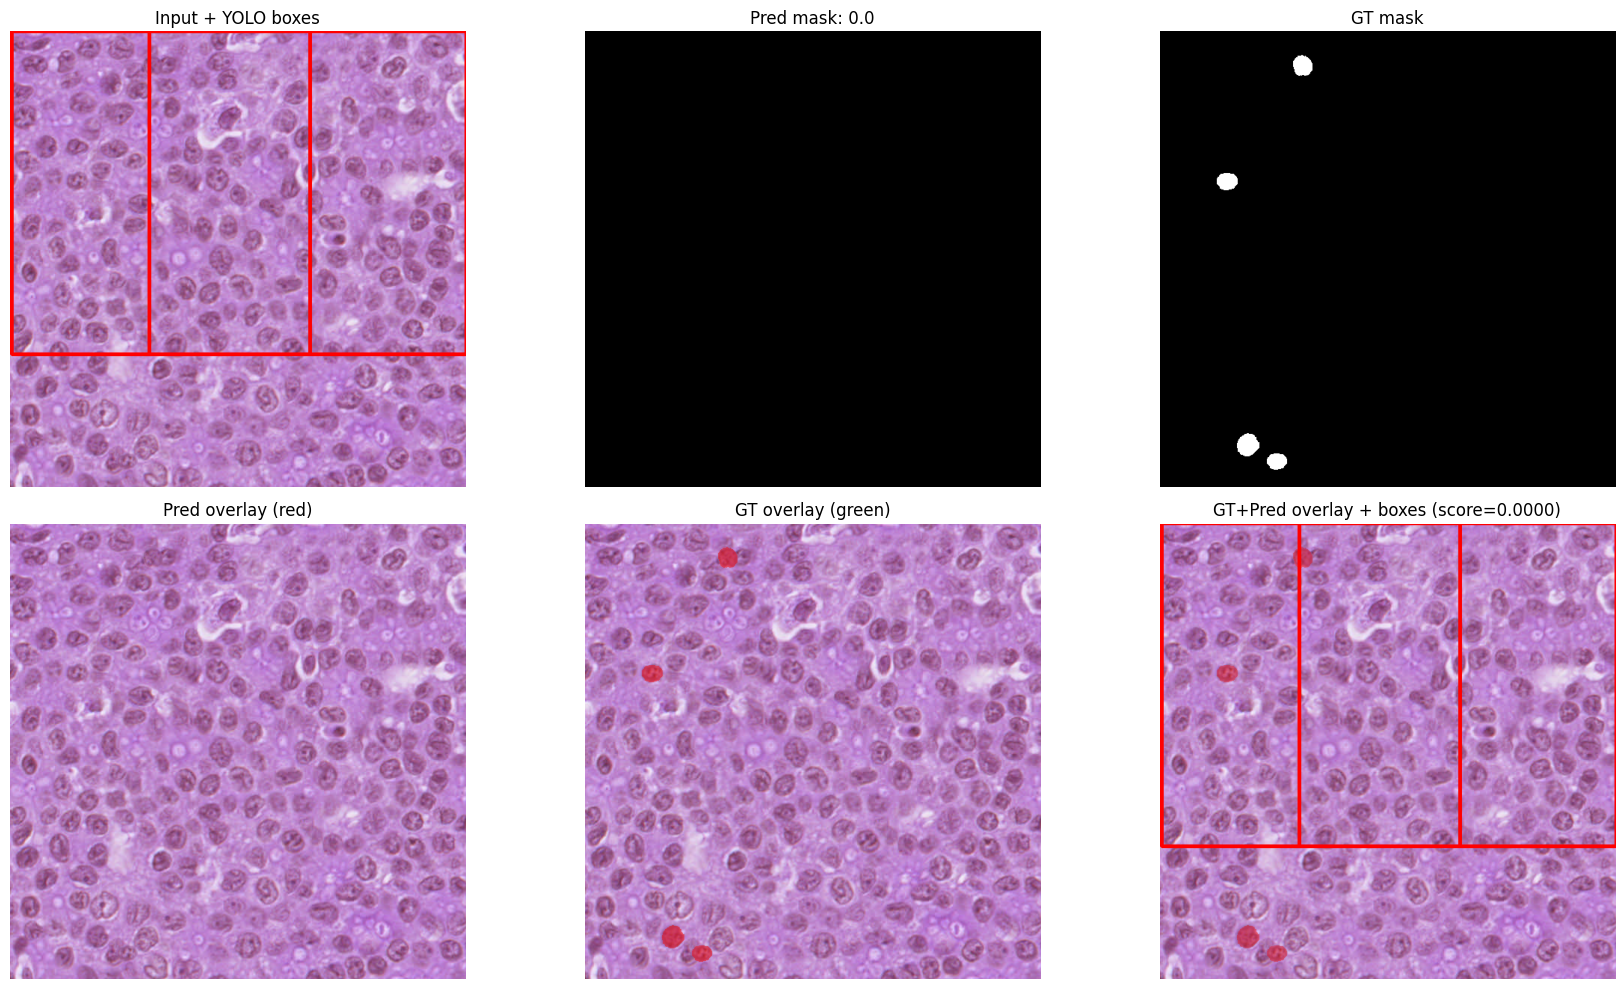

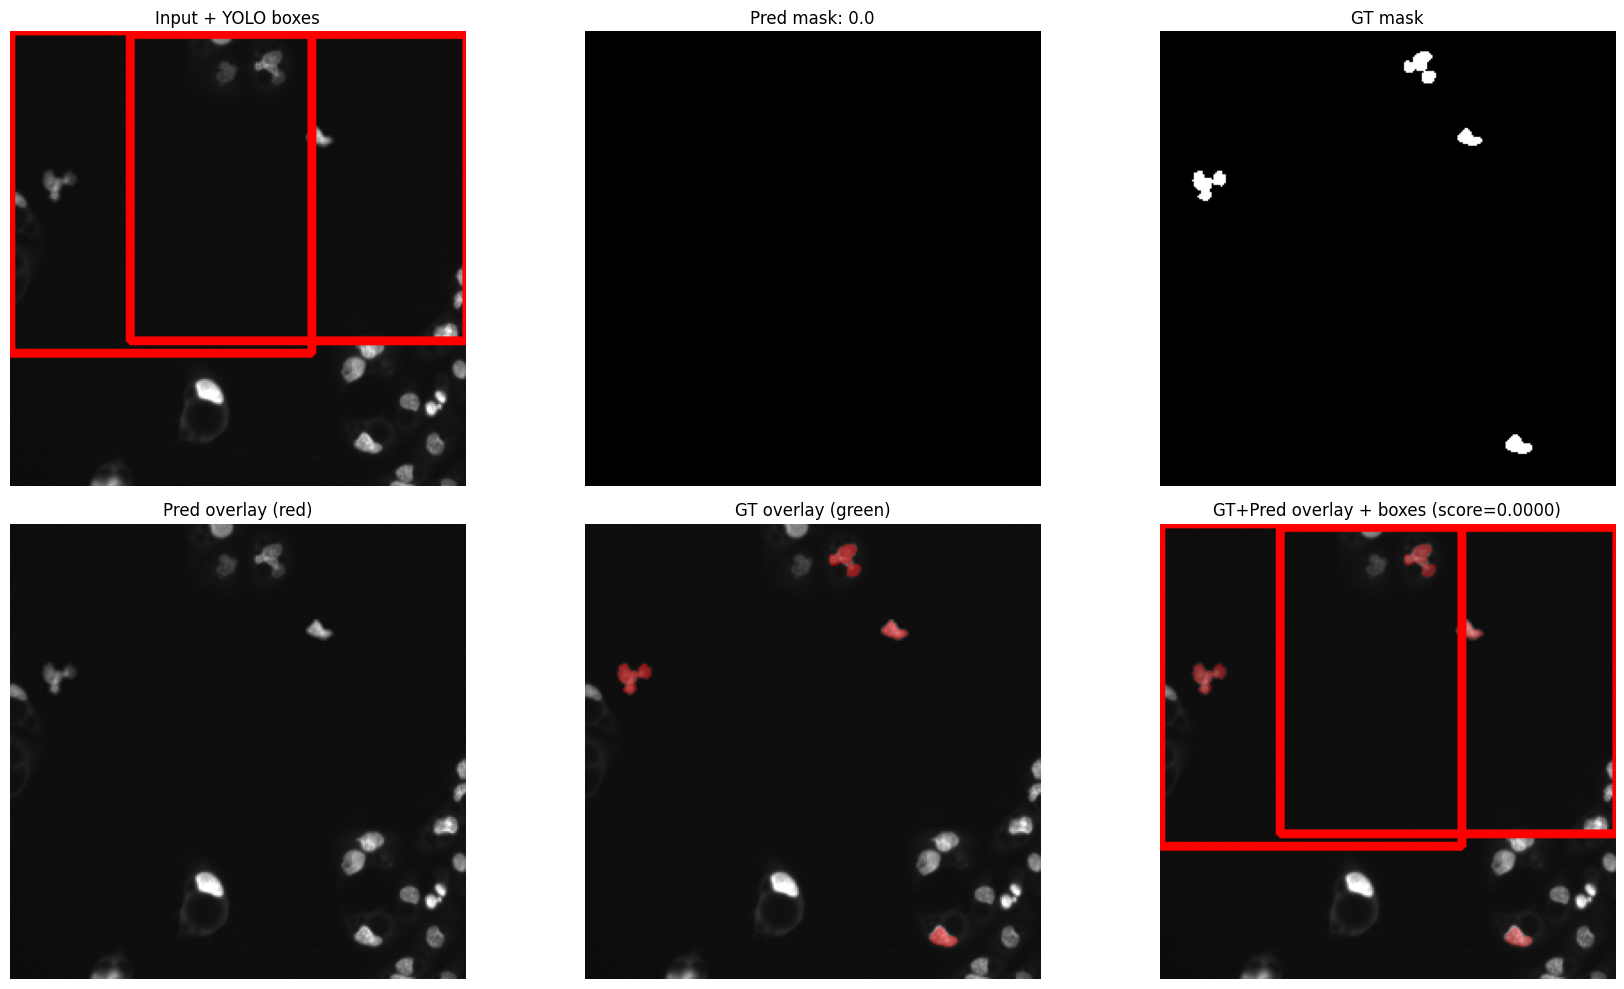

,case_id,annotation
0,50028,authentic
1,18054,authentic
2,32154,authentic
3,51742,"[1995191, 15, 1997103, 15, 1999015, 15, 200092..."


In [8]:
if Config.SUBMISSION_MODE:
    img_dir = Config.TEST_IMG_DIR
else:
    img_dir = Config.TRAIN_IMG_DIR
    # img_dir = Config.SUPPLEMENTAL_IMG_DIR

sub_df = inference(
    weight_path = Path(
        "/kaggle/input/recodai-nposw-uperhead-more-aug-dinov2-uperhead/20260115_182834/vit_base_patch14_dinov2.lvd142m_fold0.pt"
    ),
    arch = "dinov2_uperhead",
    img_dir = Path(img_dir),
    samples = 3,
)
sub_df